In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization
from tensorflow.compat.v1.train import RMSPropOptimizer, AdamOptimizer
from tensorflow.nn import elu, relu, softmax
from tensorflow.nn import sparse_softmax_cross_entropy_with_logits
from tensorflow.contrib.layers import xavier_initializer

In [ ]:
class PGPixelNet(object):
    def __init__(self, alpha, gamma, input_dims, num_actions):
        self.alpha = alpha
        self.gamma = gamma
        self.input_depth, self.input_height, self.input_width = input_dims
        self.action_space = [i for i in range(num_actions)]
        self.num_actions = num_actions
        self.states_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.done_memory = []
        self.sess = tf.Session()
        self.build_net()
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()
        self.model_file = 'drive/My Drive/policygrads/tfagent_spaceinvaders'

    def build_net(self):
        self.states = tf.placeholder(tf.float32, shape=[
                        None,
                        self.input_height,
                        self.input_width,
                        self.input_depth
                        ])
        self.labels = tf.placeholder(tf.int32, shape=[None,])
        self.advantage = tf.placeholder(tf.float32, shape=[None,])

        conv1 = Conv2D(32, 8, strides=4,
                       kernel_initializer=xavier_initializer())(self.states)
        bn1 = BatchNormalization(epsilon=1e-5)(conv1)
        layer1 = relu(bn1)

        conv2 = Conv2D(64, 4, strides=2,
                       kernel_initializer=xavier_initializer())(layer1)
        bn2 = BatchNormalization(epsilon=1e-5)(conv2)
        layer2 = relu(bn2)

        conv3 = Conv2D(128, 3, strides=1,
                       kernel_initializer=xavier_initializer())(layer2)
        bn3 = BatchNormalization(epsilon=1e-5)(conv3)
        layer3 = relu(bn3)

        flat = Flatten()(layer3)

        dense1 = Dense(256, activation=relu,
                            kernel_initializer=xavier_initializer())(flat)

        dense2 = Dense(self.num_actions,
                            kernel_initializer=xavier_initializer())(dense1)
        self.actions = softmax(dense2)

        negloss = sparse_softmax_cross_entropy_with_logits(
                        logits=dense2,
                        labels=self.labels
                        )

        self.policyloss = tf.reduce_mean(negloss * self.advantage)

        self.optimize = RMSPropOptimizer(self.alpha, epsilon=1e-6, momentum=0.0,
                               decay=0.99).minimize(self.policyloss)

    def choose_action(self, states):
        states = states.reshape(-1, 
                                self.input_height, 
                                self.input_width, 
                                self.input_depth)
        probs = self.sess.run(self.actions, feed_dict={self.states:states})[0]
        action = np.random.choice(self.action_space, p=probs)

        return action

    def store_transition(self, states, action, reward, done):
        self.states_memory.append(states)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        self.done_memory.append(done)

    def alternate_rewards(self, rewards):
        advantage = np.zeros_like(rewards)
        for t in range(len(rewards)):
            asum = 0
            discount = 1
            for k in range(t, len(rewards)):
                if t > 0 and rewards[k] - rewards[k-1] < 0:
                    break
                asum += rewards[k] * discount
                discount *= self.gamma
            advantage[t] = asum

        mean = np.mean(advantage)
        std = np.std(advantage) if np.std(advantage) > 0 else 1
        advantage = (advantage - mean) / std

        return advantage

    def learn(self):
        states = np.array(self.states_memory).reshape(
                    (-1, self.input_height, self.input_width, self.input_depth))
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        dones = np.array(self.done_memory)

        advantage = self.alternate_rewards(rewards)

        loss = self.sess.run(self.optimize, feed_dict={
            self.states: states,
            self.labels: actions,
            self.advantage: advantage
        })

        self.states_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.done_memory = []

    def load_checkpoint(self):
        print("...Loading checkpoint...")
        self.saver.restore(self.sess, self.model_file)

    def save_checkpoint(self):
        print("...Saving checkpoint...")
        self.saver.save(self.sess, self.model_file)

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
env = gym.make('SpaceInvaders-v0')
num_frames = 4
state_size = (95, 185)
num_actions = env.action_space.n
agent = PGPixelNet(alpha=0.001, gamma=0.9, input_dims=(1, 185, 95), 
                   num_actions=num_actions)

In [ ]:
import PIL
from PIL import Image

In [ ]:
def resize_state(state, size):
    state = state[15:200, 30:125]
    state = Image.fromarray(np.uint8(state))
    state = state.resize(size)
    state = np.array(state)
    return state


def normalize_state(state):
    return np.mean(state, axis=2)


def preprocess_state(state, size):
    state = resize_state(state, size)
    state = normalize_state(state)
    return state

In [ ]:
obs = env.reset()

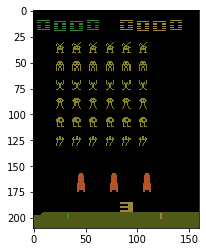

In [ ]:
plt.imshow(obs)

In [ ]:
state = preprocess_state(obs, state_size)

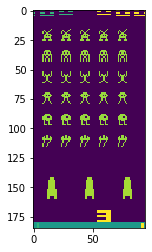

In [ ]:
plt.imshow(state)

In [ ]:
from collections import deque

# Initialize deque with zero-images one array for each image

def stack_frames(stack, frame, new):
    
    if new:
        # Clear our stacked_frames
        stack = deque([np.zeros((185,95), dtype=np.int) for i in range(4)], 
                      maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stack.append(frame)
        stack.append(frame)
        stack.append(frame)
        stack.append(frame)
        
        # Stack the frames
        state = np.stack(stack, axis=2)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stack.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        state = np.stack(stack, axis=2) 
    
    return state, stack

In [ ]:
buffer, stack = stack_frames(stack=None, frame=state, new=True)

In [ ]:
buffer = np.moveaxis(buffer, -1, 0)

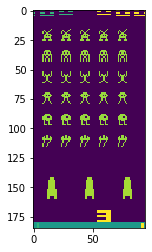

In [ ]:
plt.imshow(buffer[0])

In [ ]:
def plot_buffer(buffer):
    fig = plt.figure(figsize=[10, 20])
    for i in range(4):
        fig.add_subplot(1, 4, i+1)
        plt.imshow(buffer[:,:,i])
    plt.show()


def preprocess_obs(observation):
    return np.mean(observation[15:200, 30:125], axis=2)


def stack_frames(stacked_frames, frame, buffer_size):
    if stacked_frames is None:
        stacked_frames = np.zeros((buffer_size, *frame.shape))
        for idx, _ in enumerate(stacked_frames):
            stacked_frames[idx,:] = frame
    else:
        stacked_frames[0:buffer_size-1,:] = stacked_frames[1:,:]
        stacked_frames[buffer_size-1, :] = frame

    return stacked_frames

def train_pixelnet(env, agent, state_size):
    score = 0
    score_history = []
    num_epsiodes = 1000
    save_episodes = 10
    stack = None

    for e in range(num_epsiodes):
        obs = env.reset()
        state = preprocess_obs(obs)
        done = False
        stack = stack_frames(stack, state, 4)
        score = 0
        avg_score = np.mean(score_history[max(0, e-20):(e+1)])
        tot_avg = np.mean(score_history)

        while not done:
            action = agent.choose_action(stack)
            observation, reward, done, info = env.step(action)
            state = preprocess_obs(observation)
            stack = stack_frames(stack, state, 4)
            agent.store_transition(state, action, reward, done)

            score += reward

        if e % 20 == 0 and e > 0:
            print('episode: ', e,
                  'score: ', score, 
                  'average score %.3f' % avg_score,
                  'total average so far %.3f' % tot_avg)
        else:
            print('episode: ', e,'score: ', score)

        if e % 3 == 0:
            agent.learn()
            
        score_history.append(score)

In [ ]:
train_pixelnet(env, agent, (95, 185))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode:  0 score:  180.0
episode:  1 score:  410.0
episode:  2 score:  210.0
episode:  3 score:  105.0
episode:  4 score:  180.0
episode:  5 score:  105.0
episode:  6 score:  175.0
episode:  7 score:  180.0
episode:  8 score:  210.0
episode:  9 score:  155.0
episode:  10 score:  155.0
episode:  11 score:  225.0
episode:  12 score:  155.0
episode:  13 score:  155.0
episode:  14 score:  180.0
episode:  15 score:  210.0
episode:  16 score:  260.0
episode:  17 score:  210.0
episode:  18 score:  180.0
episode:  19 score:  185.0
episode:  20 score:  155.0 average score 191.250 total average so far 191.250
episode:  21 score:  240.0
episode:  22 score:  180.0
episode:  23 score:  425.0
episode:  24 score:  185.0
episode:  25 score:  180.0
episode:  26 score:  335.0
episode:  27 score:  185.0
episode:  28 score:  180.0
episode:  29 score:  180.0
episode:  30 score:  290.0
episode:  31 score:  180.0
episode:  32 score:  185.0
episode:  33 score:  180.0
episode:  34 score:  180.0
episode:  35 s